# Robust detrending, rereferencing, outlier detection, and inpainting, for-multichannel-data

Implementation of [1] in Python and experiments on real time series.  
Esteban Christiann (ENS Paris-Saclay) and Alexi Canesse (ENS de Lyon)

### Libraries Importation

In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from meegkit.utils.sig import stmcb # Steiglitz-McBride iteration method for ringing removal
from alphacsc import learn_d_z
try:
    from alphacsc.utils import construct_X
except:
    from alphacsc.utils.convolution import construct_X

### Data loading
Load MEG data extracted from [2] *(See the end of the notebook for the data extraction)*

In [2]:
cool_channels = [3, 12, 15, 19, 22]
FS = 2400 # Sampling frequency = 2400Hz

meg_data = np.load("data/MEG.npy")

print(meg_data.shape)

(576000, 303)


### Data Generation

Three channel synthetic data with linear dependancy (according to model 2 in [1])

In [3]:
num_points = 300
t, x1, _ = utils.generate_noisy_polynomial(degree=10, noise_level=0.2, num_points=num_points)
_, x2, _ = utils.generate_noisy_polynomial(degree=10, noise_level=0.2, num_points=num_points)
x3 = x1 + x2 + np.random.normal(scale=0.2, size=[num_points])
x = np.stack([x1, x2, x3], axis=1)
x_not_corrupted = x.copy()

Add some corruption to it

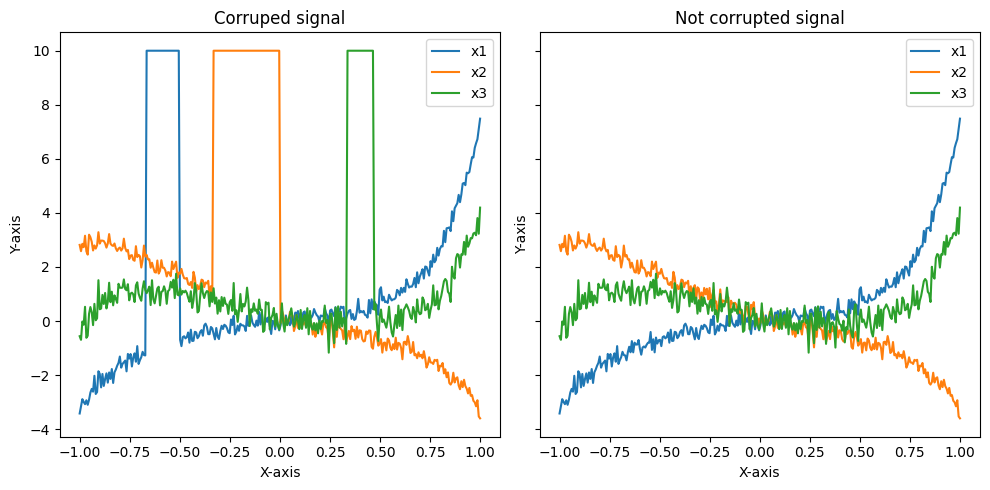

In [4]:
w = np.ones([num_points, 3], dtype=bool)
w[50:75, 0] = False
w[100:150, 1] = False
w[200:220, 2] = False
x[~w] = 10
x1, x2, x3 = x.T

utils.plot_signals_side_by_side(t, x.T, x_not_corrupted.T, y_names1=["x1", "x2", "x3"], y_names2=["x1", "x2", "x3"], title1="Corruped signal", title2="Not corrupted signal")

Synthetic data with steps

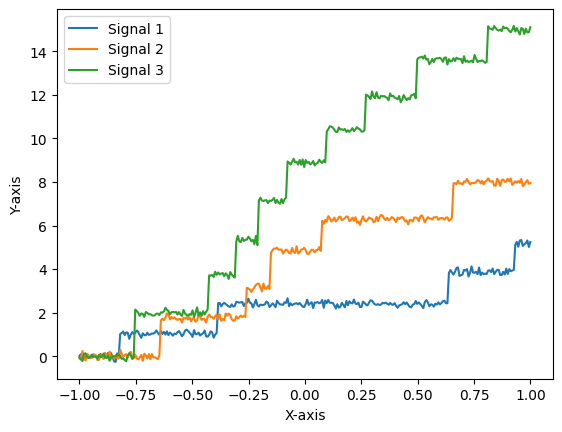

In [5]:
# Data with steps 
sigma = 1e-1
x_step = np.random.randn(3, num_points) * sigma
# Add steps
for signal in x_step:
    step_locations = utils.generate_random_numbers(np.random.randint(3, 10), 10, num_points - 9, 15)
    for step_location in step_locations:
        signal[step_location:] += 1. + np.random.random()
utils.plot_signals(t, x_step, title="")

## 1. Robust detrending

In [6]:
def robust_detrend(x, order, w=None, basis='polynomials', thresh=0.5, maxiter=20):
     """
     Robustly removes trend from data.

     Parameters:
     - x: raw data
     - order: order of polynomial or number of sin/cosine pairs
     - w: weights
     - basis: 'polynomials' [default] or 'sinusoids', or user-provided matrix
     - thresh: threshold for outliers [default: .5 sd]
     - maxiter: number of iterations [default: 20]

     Returns:
     - original - trend: detrended data
     - trend: trend
     - w: updated weights
     - r: basis matrix used
     """
     # Generate basis matrix
     if isinstance(basis, np.ndarray):
          r = basis
     else:
          lin = np.linspace(-1, 1, x.shape[0])
          if basis == 'polynomials':
               r = np.column_stack([lin ** k for k in range(0, order + 1)])
          elif basis == 'sinusoids':
               r = np.column_stack([np.sin(2 * np.pi * k * lin / 2) for k in range(0, order + 1)] +
                                   [np.cos(2 * np.pi * k * lin / 2) for k in range(0, order + 1)])
          else:
               raise ValueError("Invalid basis type")

     # Initialize weights if not provided
     if w is None:
          if len(x.shape) == 1:
               w = np.ones_like(x, dtype=bool)[:, np.newaxis]
          else:
               w = np.ones_like(x, dtype=bool)[:]
     
     # If the data is multichannel, the algorithm is applied to each channel independently 
     trend = x.copy()
     original = x.copy()
     if len(trend.shape) == 1:
          trend = trend[:, np.newaxis]
          original = original[:, np.newaxis]
     for _ in range(maxiter):
          # If the data is multichannel, the algorithm is applied to each channel independently 
          for dim in range(trend.shape[1]):
               # Fit to basis
               coefficients, _, _, _ = np.linalg.lstsq(r[w[:, dim],:], original[w[:, dim], dim], rcond=None)
               trend[:,dim] = r @ coefficients
               # Update weights
               d = np.abs(trend[:, dim] - original[:, dim])

               new_w = d < thresh * np.std(d)
               if (new_w == w[:, dim]).all():
                    # Algorithm converged, early stopping
                    break
               w[:, dim] = new_w


     return original - trend, trend, w, r

### Try the algorithm on our generated data

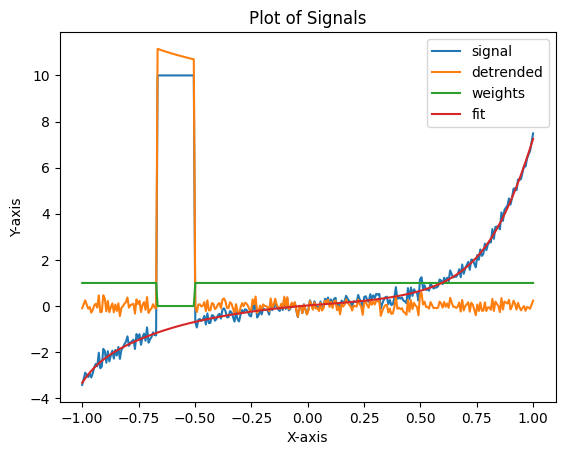

In [7]:
detrended_x1, trend_x1, weights_x1, _ = robust_detrend(x1, 10, thresh=1)
utils.plot_signals(t, [x1, detrended_x1[:, 0], weights_x1, trend_x1], y_names=["signal", "detrended", "weights", "fit"])

### Try the algorithm on real MEG data

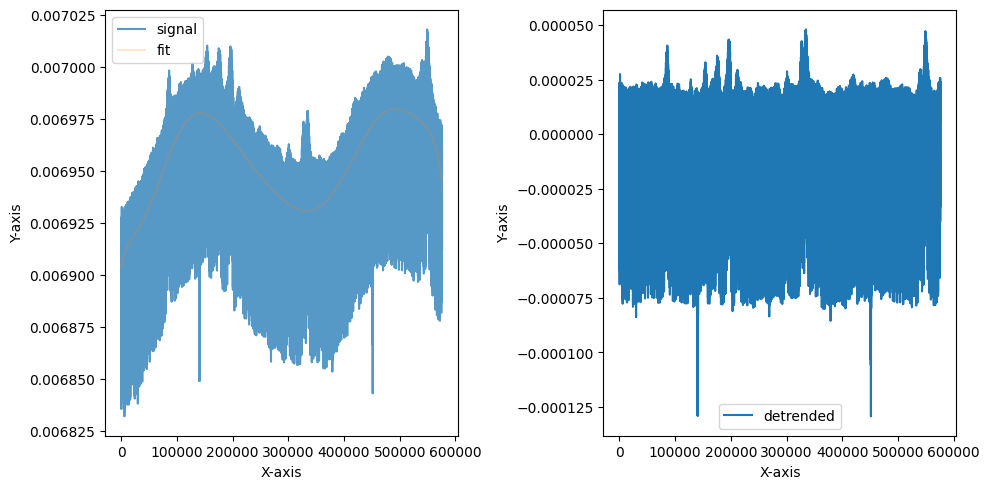

In [8]:
meg_chan = meg_data[:, 22]
detrended_meg, trend_meg, _, _ = robust_detrend(meg_chan, 10, thresh=1)
utils.plot_signals_side_by_side(np.arange(meg_chan.shape[0]), [meg_chan, trend_meg], [detrended_meg[:, 0]], y_names1=["signal", "fit"], y_names2=["detrended"], alpha1=[.75, .2, 1.], sharey=False)

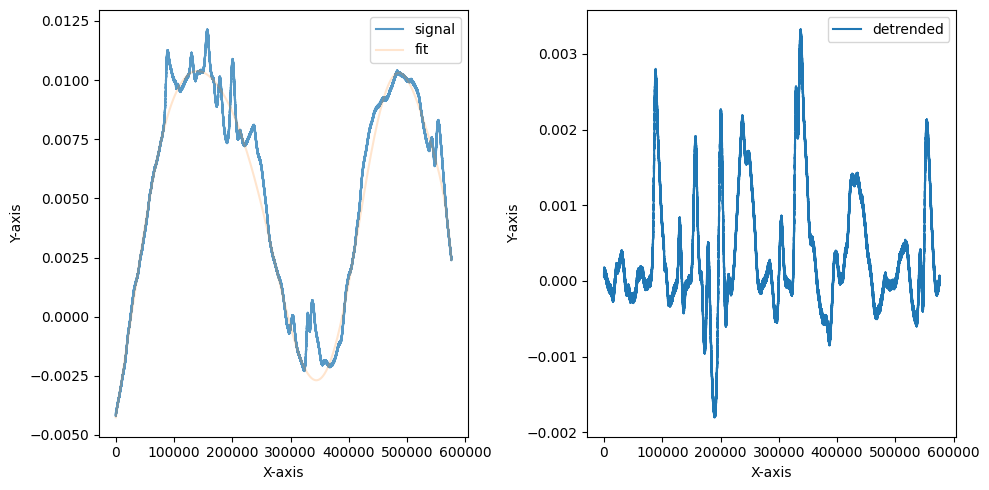

In [9]:
meg_chan = meg_data[:, 3]
detrended_meg, trend_meg, _, _ = robust_detrend(meg_chan, 10, thresh=1)
utils.plot_signals_side_by_side(np.arange(meg_chan.shape[0]), [meg_chan, trend_meg], [detrended_meg[:, 0]], y_names1=["signal", "fit"], y_names2=["detrended"], alpha1=[.75, .2, 1.], sharey=False)

## 2. Inpainting

In [10]:
def inpaint(x, w, keep_valid=True):
    """
    Reconstruct data if corrupted samples are known

    Parameters:
    - x: Nchannels x Nsamples raw data
    - w: Nchannels x Nsamples bool matrix indicating corruptions
    - keep_valid: set to true to reconstruct only corrupted samples

    Returns:
    - new_x: reconstructed data
    """
    if w is None:
        w = np.ones_like(x, dtype=bool)

    N = x.shape[1] # Number of channels
    new_x = x.copy()
    
    # Optimization trick: represent bool matrix using 1 bit for each coefficient
    packed_w = np.packbits(w, axis=1)
    full_pattern, full_partition = np.unique(packed_w, axis=0, return_inverse=True)
    full_pattern = np.unpackbits(full_pattern, axis=1, count=N).astype(bool)

    for n in range(N):

        # Partition the time axis using the state of other channels
        pattern = full_pattern.copy()
        pattern[:, n] = False 
        pattern = np.packbits(pattern, axis=1) # Optimization again...
        pattern, partition = np.unique(pattern, axis=0, return_inverse=True)
        pattern = np.unpackbits(pattern, axis=1, count=N).astype(bool)
        partition = partition[full_partition]
        
        K = pattern.shape[0]

        for k in range(K):

            T_k = partition == k
            Tprime_k = np.logical_and(w[:, n], T_k) # Timestamps we use to estimate the projection
            
            Tinpaint = np.logical_and(~w[:, n], T_k) # Timestamps to reconstruct
            if not keep_valid:
                Tinpaint = T_k

            if Tinpaint.any():
                xother_Tp = x[Tprime_k, :][:, pattern[k]]
                ones = np.ones([xother_Tp.shape[0], 1], dtype=np.float32)
                xother_Tp = np.concatenate([xother_Tp, ones], axis=1)

                xother_Ti = x[Tinpaint, :][:, pattern[k]]
                ones =  np.ones([xother_Ti.shape[0], 1], dtype=np.float32)
                xother_Ti = np.concatenate([xother_Ti, ones], axis=1)
                
                # Estimate the coefficients and reconstuct the data
                coefs = np.linalg.lstsq(xother_Tp, x[Tprime_k, n], rcond=None)[0]
                new_x[Tinpaint, n] = xother_Ti @ coefs

    return new_x

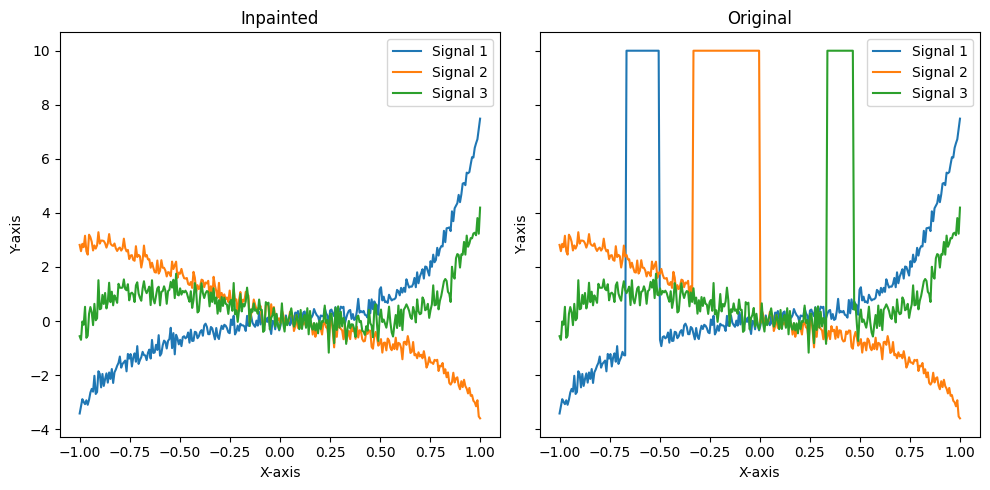

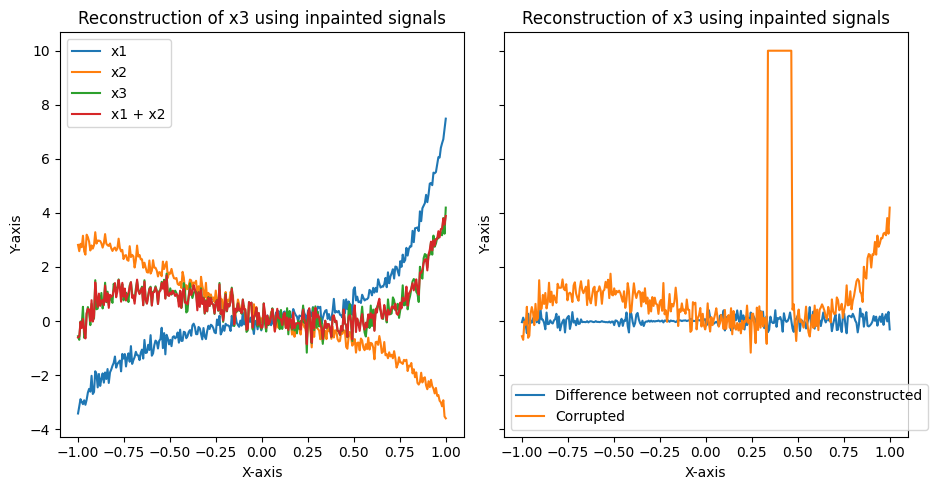

In [11]:
x_inpaint = inpaint(x, w)

utils.plot_signals_side_by_side(t, x_inpaint.T, x.T, title1="Inpainted", title2="Original")

to_plot = np.concatenate([x_inpaint, x_inpaint[:, [0]] + x_inpaint[:, [1]]], axis=1)
utils.plot_signals_side_by_side(t, to_plot.T, [x_inpaint[:, 0] + x_inpaint[:, 1] - x_not_corrupted[:,2], x[:,2]], y_names1=["x1", "x2", "x3", "x1 + x2"], y_names2=["Difference between not corrupted and reconstructed", "Corrupted"], title1="Reconstruction of x3 using inpainted signals", title2="Reconstruction of x3 using inpainted signals")

## 3. Outlier Detection

In [12]:
def outlier_detection(x, thres=2., maxiter=20):
    """
    Flag outliers using the inpaint algorithm

    Parameters:
    - x: Nchannels x Nsamples raw data
    - thres: threshold for outlier detection (default: 2 stddev)
    - maxiter: maximum number of iterations

    Returns:
    - w: Nchannels x Nsamples bool matrix where False indicates an outlier
    """
    w = np.ones_like(x, dtype=bool) # Initially assume there are no outliers

    for it in range(maxiter):
        # Try to reconstruct the data using the inpainting algorithm
        xbar = inpaint(x, w, keep_valid=False)

        # Flag high reconstruction errors as outliers
        d = np.abs(x - xbar)
        new_w = ~(d > thres * d.std(axis=0, keepdims=True))

        print(f"[Outlier] Iteration {it+1}/{maxiter}: {100 * (~new_w).sum() / new_w.size:.2f}% flagged as outliers")
        
        # Early stopping if the algorithm has converged
        if (w == new_w).all():
            print(f"[Outlier] Done.")
            return w
        w = new_w
    
    return w

[Outlier] Iteration 1/20: 10.78% flagged as outliers
[Outlier] Iteration 2/20: 10.56% flagged as outliers
[Outlier] Iteration 3/20: 10.56% flagged as outliers
[Outlier] Done.


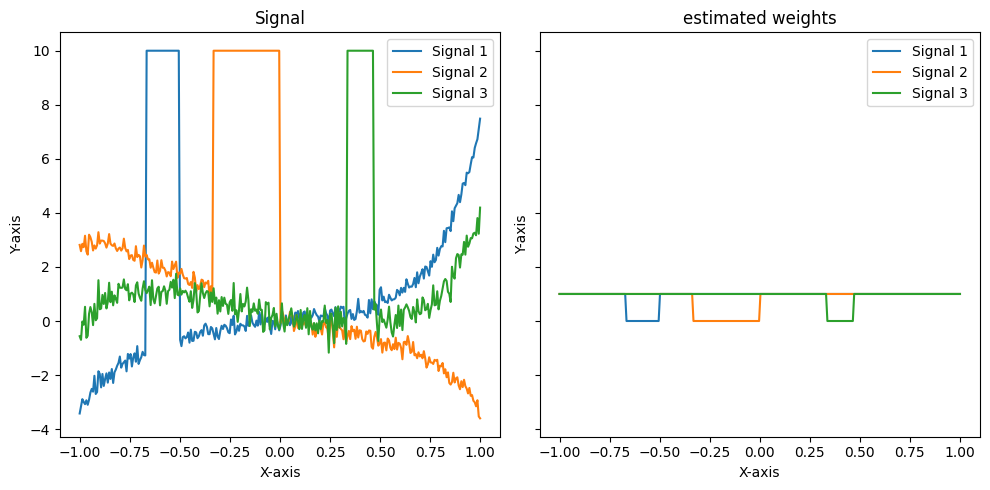

In [13]:
estimated_w = outlier_detection(x)
utils.plot_signals_side_by_side(t, x.T, estimated_w.T, title1="Signal", title2="estimated weights")

## 4. Robust Rereferencing

In [14]:
def robust_rereferencing(x, w=None):
    """
    Perform robust referencing on the input signal.

    Parameters:
    - x (numpy.ndarray): Input signal.
    - w (numpy.ndarray): Weights from outlier detection.

    Returns:
    - numpy.ndarray: Robustly referenced signal.
    """
    if w is None:
        w = outlier_detection(x)
    robust_mean = np.mean(x, where=w)
    return x - robust_mean

### Trying it on our generated data

[Outlier] Iteration 1/20: 10.78% flagged as outliers
[Outlier] Iteration 2/20: 10.56% flagged as outliers
[Outlier] Iteration 3/20: 10.56% flagged as outliers
[Outlier] Done.


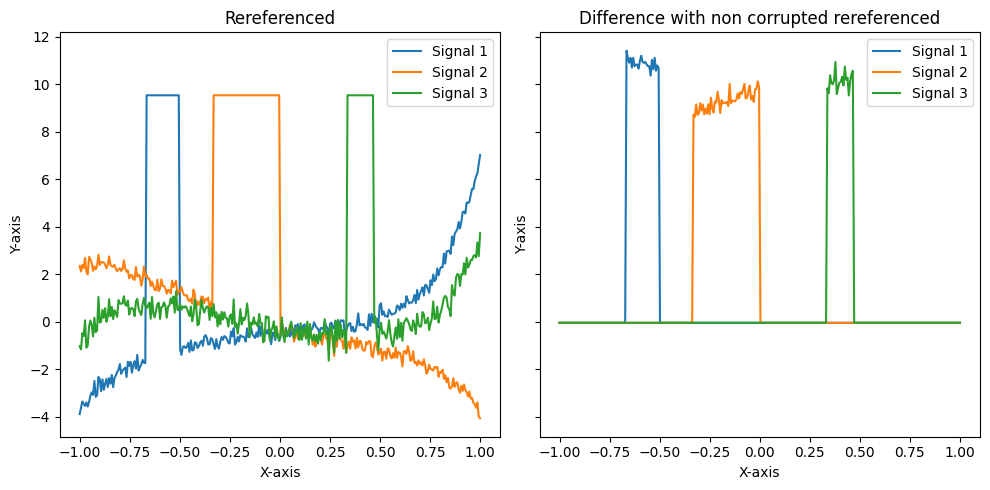

In [15]:
rereferenced_x = robust_rereferencing(x)
utils.plot_signals_side_by_side(t, rereferenced_x.T, rereferenced_x.T - (x_not_corrupted.T - np.mean(x_not_corrupted)), title1="Rereferenced", title2="Difference with non corrupted rereferenced")

## 5. Step Removal

In [16]:
def find_steps(x, thresh, guard, depth):
    """
    Find step glitch

    Parameters:
    - x (numpy.ndarray): Data to clean.
    - thresh (float): Threshold
    - guard (int): Minimum duration of stable interval in samples .
    - depth (int): Recursion depth, determines the number of steps.

    Returns:
    - stepList (list): Indices of steps.
    """
    if depth == 0 or x.shape[0] <= 2 * guard:
        return []

    T = x.shape[0] # x is a single channel here

    M0 = np.cumsum(x) / np.arange(1, T+1)
    V0 = np.cumsum(np.square(x)) / np.arange(1, T+1)
    V0 -= np.square(M0)
    V0 *= np.arange(1, T+1)

    MT = np.cumsum(x[::-1]) / np.arange(1, T+1)
    VT = np.cumsum(np.square(x[::-1])) / np.arange(1, T+1)
    VT -= np.square(MT)
    VT *= np.arange(1, T+1)
    VT = VT[::-1]
    
    t0 = np.argmin((V0 + VT)[guard : T-guard])
    steps = [guard + t0]
    
    # Check if the step is relevent 
    if (V0[t0] + VT[t0]) / V0[-1] > thresh:
        return []

    if depth and steps:
        steps_left = find_steps(x[:steps[0]], thresh=thresh, guard=guard, depth=depth-1)
        # Add an offset because x[steps[0] + 1] becomes index 0
        steps_right = steps[0] + find_steps(x[steps[0]+1:], thresh=thresh, guard=guard, depth=depth-1)
        steps = np.concatenate((steps_left, steps, steps_right))

    return steps.astype(int)

def step_removal(x, thresh=0.7, guard=5, depth=5):
    """
    Remove step glitch
    
    Parameters:
    - x (numpy.ndarray): Data to clean (time * channels).
    - thresh (float): Threshold (default: 0.7).
    - guard (int): Minimum duration of stable interval in samples (default: 5).
    - depth (int): Recursion depth (default: 5), determines the number of steps.

    Returns:
    - y (numpy.ndarray): Step-removed data.
    - stepList (list): Indices of steps.
    """

    y = x.copy()

    all_stepList = []
    for chan in range(x.shape[1]):
        # Find step indices
        stepList = find_steps(x[:, chan], thresh=thresh, guard=guard, depth=depth)

        all_stepList.append(stepList)

        if len(stepList):
            stepList = [0] + list(stepList) + [x.shape[0]]
            for split in range(1, len(stepList) - 1):
                y1 = y[stepList[split - 1] + 1 : stepList[split] - 1, chan]  # plateau before
                y2 = y[stepList[split] + 1 : stepList[split + 1] - 1, chan]  # plateau after
                step = np.mean(y2) - np.mean(y1)
                y[stepList[split] + 1:, chan] -= step

    return y, all_stepList

### Try the algorithm on our generated data

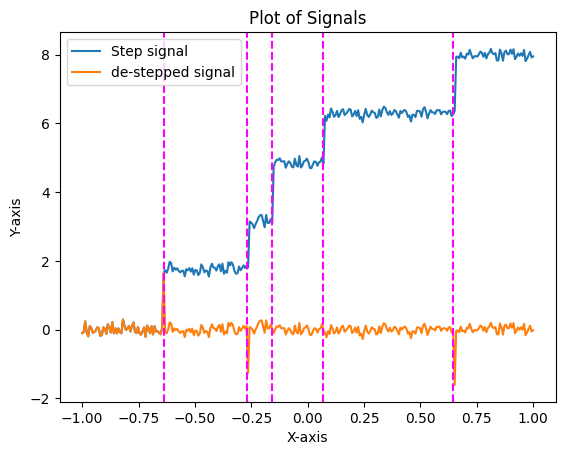

In [17]:
x_step_removed, stepList = step_removal(x_step[[1]].T, thresh=0.7)
utils.plot_signals(t, [x_step[[1]].T, x_step_removed], y_names=["Step signal", "de-stepped signal"], y_lines=[t[step] for steps in stepList for step in steps])

### Try the algorithm on real MEG data

We can see that steps are removed but ringing still present...

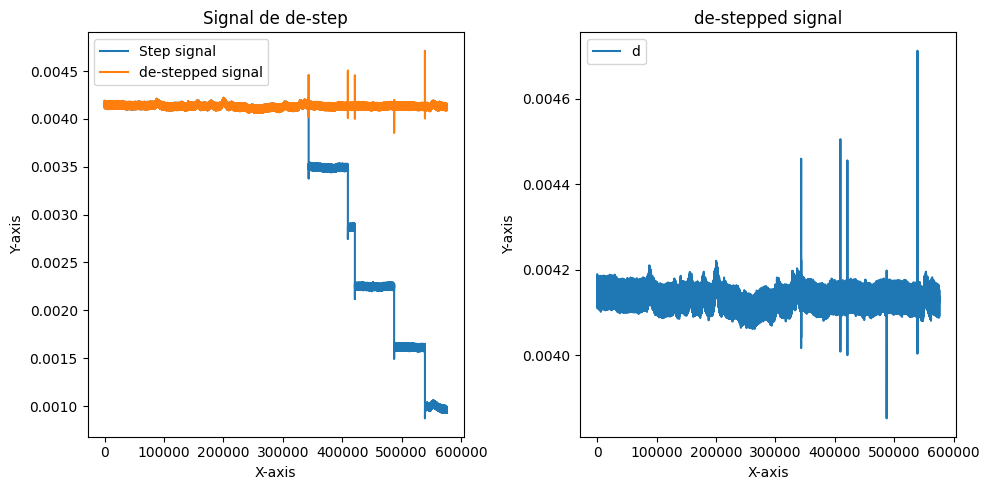

In [18]:
meg_chan = meg_data[:, [19]]
meg_nostep, step_list = step_removal(meg_chan)
utils.plot_signals_side_by_side(range(meg_data.shape[0]), y1=[meg_chan, meg_nostep], y2=[meg_nostep], y_names1=["Step signal", "de-stepped signal"], y_names2="de-stepped signal", title1="Signal de de-step", title2="de-stepped signal", sharey=False)

## 6. Ringing removal

In [19]:
def ringing_removal(x, step_list):
    """
    Reduce ringing effect caused by the antialiasing filter response to steps

    Paramters:
    - x: (Nsamples, Nchannels) data matrix
    - step_list: list of step indexes (can be found with step removal algorithm)

    Return:
    - new_x: cleaned data
    """
    N = x.shape[1]
    n_num, n_den = 8, 8
    n_samples = 100

    new_x = x.copy()
    for n in range(N):
        for step in step_list[n]:
            ringing = x[step : step+n_samples, n]
            ringing = ringing - ringing.mean()
            if ringing.shape[0] < n_samples:
                break
            ringing[n_samples//2 : ] = 0
            b, a = stmcb(ringing, q=n_num, p=n_den, niter=10)

            impulse = np.arange(n_samples) == 0
            model = lfilter(b, a, impulse)
            new_x[step : step+n_samples, n] -= model

    return new_x

### Try the algorithm on our generated data

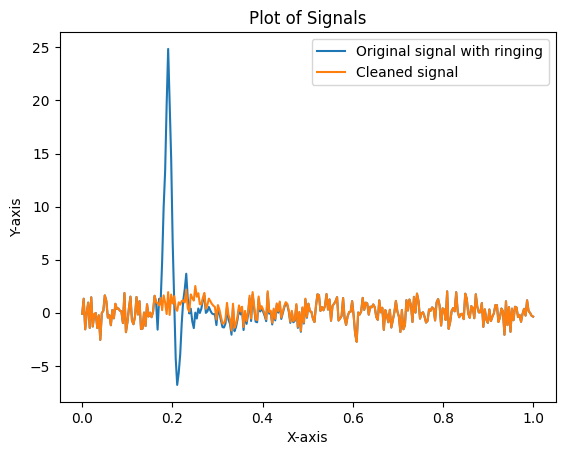

In [20]:
# Some filter
[b, a] = butter(6, 0.2)

x = np.arange(300) == 0 # An impulse...
x = lfilter(b, a, x) * 100 # ... goes through the filter
x = np.roll(x, 50) + np.random.normal(size=300)
x = x[:, None]
t = np.linspace(0, 1, x.shape[0])

# We already kown that the problem is at timestep 50, but with real data we would
# get the timesteps from the step removal algorithm
x_noring = ringing_removal(x, [[50]])
utils.plot_signals(t, [x, x_noring], y_names=["Original signal with ringing", "Cleaned signal"])

### Try the algorithm on real MEG data

We reuse the output of the step removal algorithm:

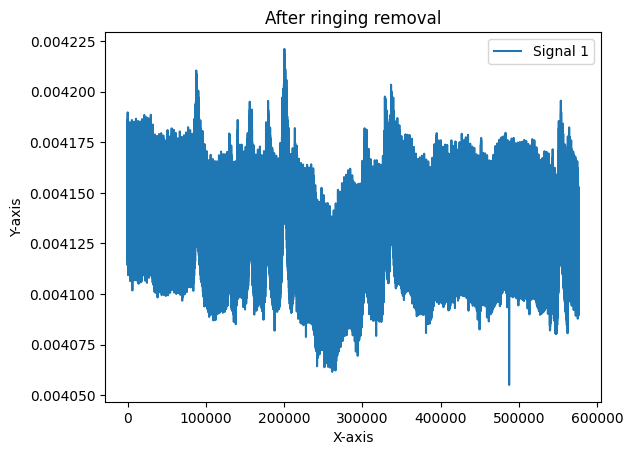

In [21]:
meg_nostep_noring = ringing_removal(meg_nostep, step_list)

utils.plot_signals(range(meg_chan.shape[0]), meg_nostep_noring.T, title="After ringing removal")

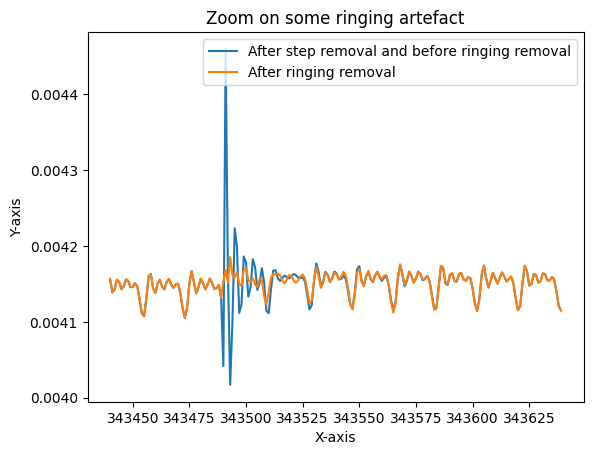

In [22]:
start, end = 343_440, 343_640
utils.plot_signals(range(start, end), [meg_nostep[start:end], meg_nostep_noring[start:end]], title="Zoom on some ringing artefact", y_names=["After step removal and before ringing removal", "After ringing removal"])

After using the ringing removal algorithm, the signal is cleaner. Data is ready for outlier detection and inpainting!

# Reconstruction using dictionary learning

In [23]:
channels = [270, 102, 19, 125, 25, 35, 24, 159, 13, 262, 28, 80, 204, 192, 211, 11]
meg = meg_data[342_000:352_000, channels]
meg = (meg - meg.mean(axis=0, keepdims=True)) / meg.std(axis=0, keepdims=True)
meg.shape

(10000, 16)

In [24]:
meg_clean, step_list = step_removal(meg)
meg_clean = ringing_removal(meg_clean, step_list)

meg_clean = robust_detrend(meg_clean, 20)[0]

w = outlier_detection(meg_clean, thres=4)
meg_clean = inpaint(meg_clean, w)

meg_clean = robust_rereferencing(meg_clean, w)
meg_clean = meg_clean - meg_clean.mean(axis=0, keepdims=True)

[Outlier] Iteration 1/20: 1.26% flagged as outliers
[Outlier] Iteration 2/20: 0.81% flagged as outliers
[Outlier] Iteration 3/20: 0.85% flagged as outliers
[Outlier] Iteration 4/20: 0.82% flagged as outliers
[Outlier] Iteration 5/20: 0.79% flagged as outliers
[Outlier] Iteration 6/20: 0.80% flagged as outliers
[Outlier] Iteration 7/20: 0.82% flagged as outliers
[Outlier] Iteration 8/20: 0.78% flagged as outliers
[Outlier] Iteration 9/20: 0.77% flagged as outliers
[Outlier] Iteration 10/20: 0.77% flagged as outliers
[Outlier] Iteration 11/20: 0.79% flagged as outliers
[Outlier] Iteration 12/20: 0.79% flagged as outliers
[Outlier] Iteration 13/20: 0.81% flagged as outliers
[Outlier] Iteration 14/20: 0.81% flagged as outliers
[Outlier] Iteration 15/20: 0.80% flagged as outliers
[Outlier] Iteration 16/20: 0.81% flagged as outliers
[Outlier] Iteration 17/20: 0.82% flagged as outliers
[Outlier] Iteration 18/20: 0.82% flagged as outliers
[Outlier] Iteration 19/20: 0.82% flagged as outliers
[O

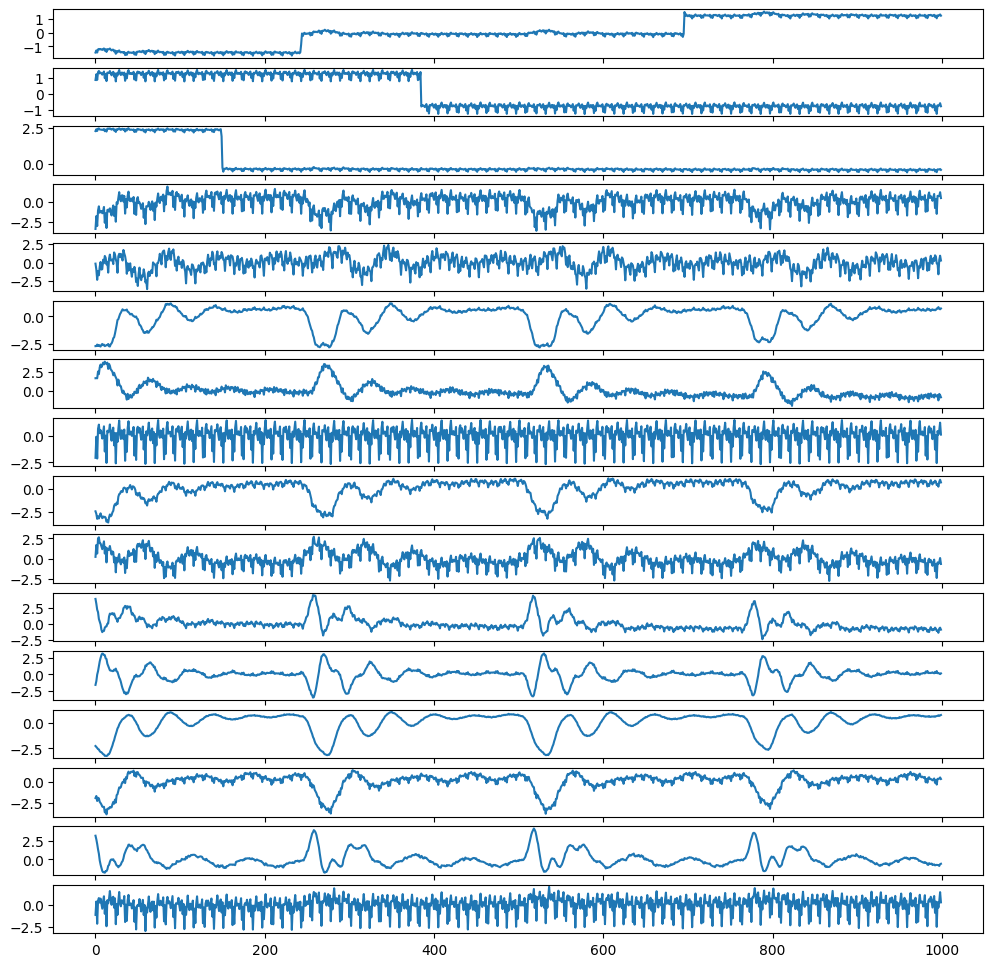

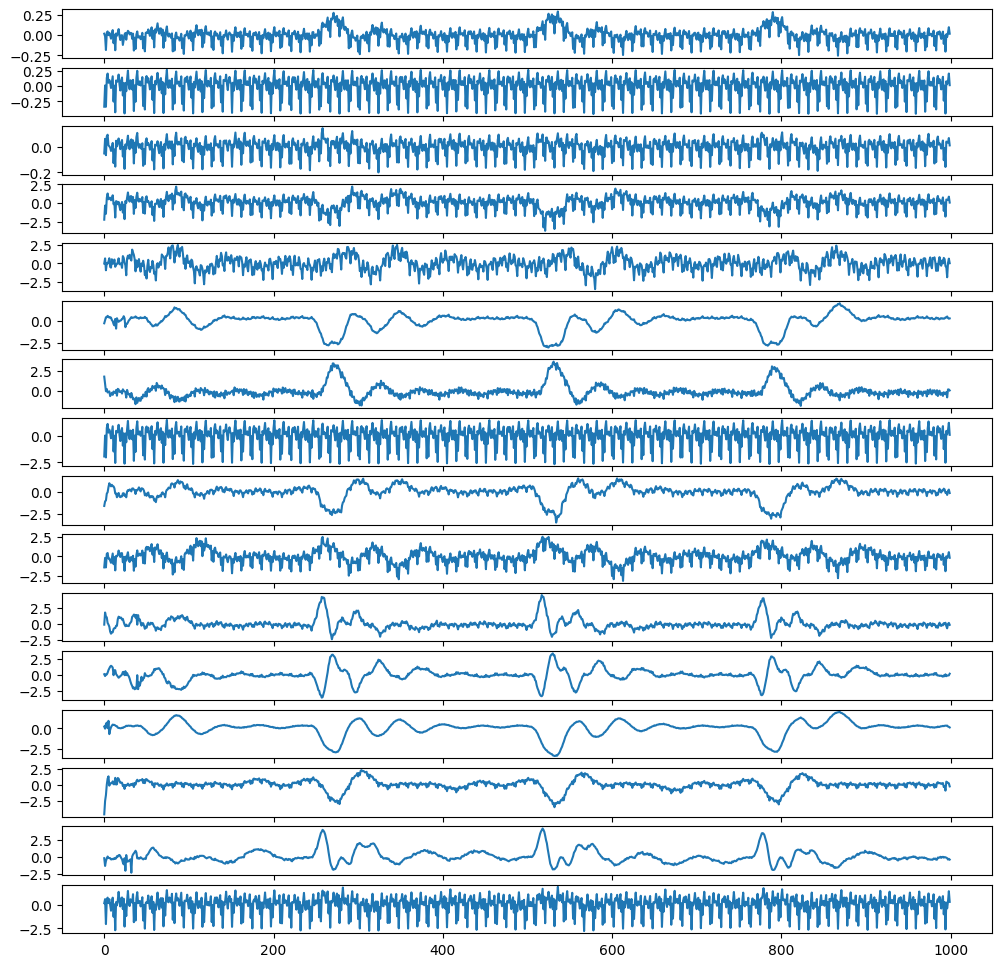

In [25]:
def plot(x, start=0, end=None):
    T, N = x.shape
    if end is None:
        end = T

    fig, axes = plt.subplots(N, sharex=True, figsize=(12, 12))
    for n in range(N):
        ax = axes[n]
        ax.plot(x[start:end, n])
    fig.show()

plot(meg[::10])
plot(meg_clean[::10])

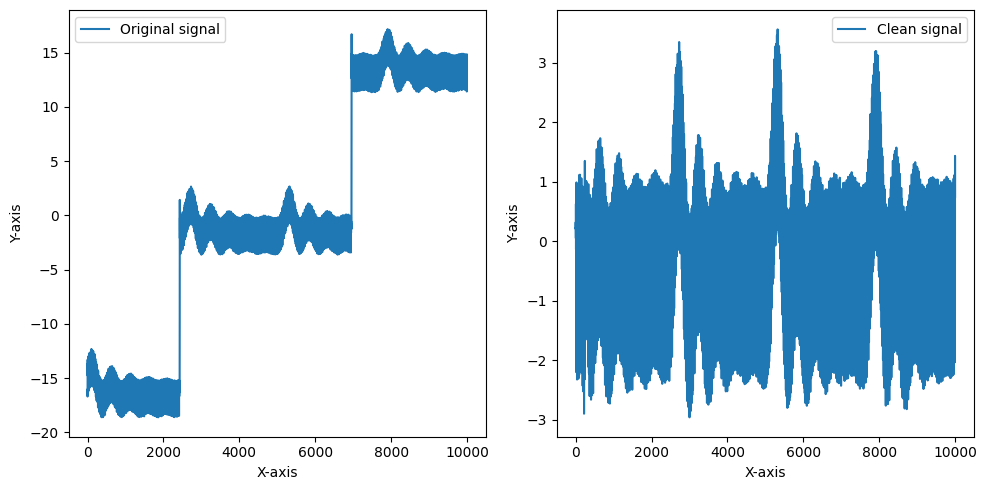

In [26]:
meg = meg[:, [0]]
meg_clean = meg_clean[:, [0]]

std = meg_clean.std()
meg /= std
meg_clean /= std

utils.plot_signals_side_by_side(range(meg.shape[0]), y1=meg.T, y2=meg_clean.T, y_names1=["Original signal"], y_names2=["Clean signal"], sharey=False)

Set parameters 

In [27]:
n_atoms = 5  # K
atom_length = 20  # L
penalty = 2. # lambda

In [28]:
# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(X=meg.T, n_atoms=n_atoms, n_times_atom=atom_length,
    reg=penalty, n_iter=20, n_jobs=8, verbose=1)

pobj_clean, _, d_hat_clean, z_hat_clean, _ = learn_d_z(X=meg_clean.T, n_atoms=n_atoms, n_times_atom=atom_length,
    reg=penalty, n_iter=20, n_jobs=8, verbose=1)

V_0/20 ...................
V_0/20 ...................


Reconstruction on the original signal

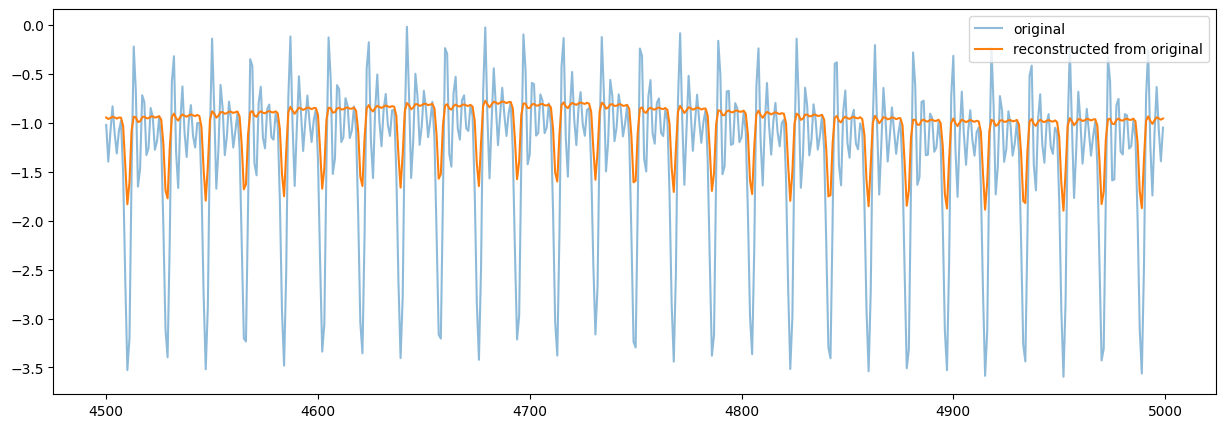

In [29]:
start, end = 4500, 5000

# Reconstruction with the dictionary and the sparse codes
reconstruction = construct_X(z_hat, d_hat).T

fig, ax = plt.subplots(figsize=(15, 5))
tt = np.arange(meg.shape[0])
ax.plot(tt[start:end], meg[start:end], label="original", alpha=0.5)
ax.plot(tt[start:end], reconstruction[start:end], label="reconstructed from original")
_ = plt.legend()
plt.show()

Re construction on the signal with step removed

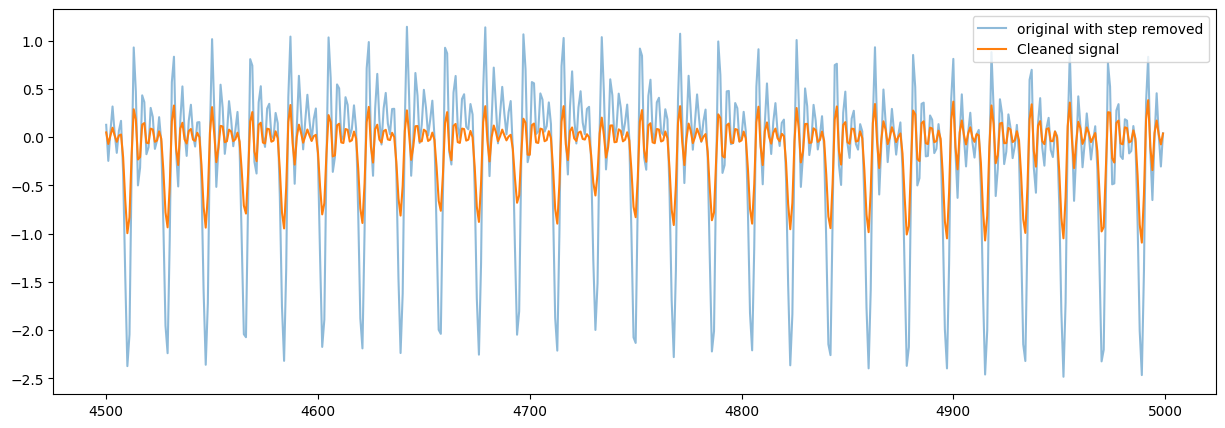

In [30]:
# Reconstruction with the dictionary and the sparse codes
reconstruction_clean = construct_X(z_hat_clean, d_hat_clean).T

fig, ax = plt.subplots(figsize=(15, 5))
tt = np.arange(meg_clean.shape[0])
ax.plot(tt[start:end], meg_clean[start:end], label="original with step removed", alpha=0.5)
ax.plot(tt[start:end], reconstruction_clean[start:end], label="Cleaned signal")

_ = plt.legend()
plt.show()

Error on both reconstruction

In [31]:
print(f"Reconstruction MSE (original): {np.mean((meg - reconstruction)**2):.3e}")
print(f"Reconstruction MSE (step removed): {np.mean((meg_clean - reconstruction_clean)**2):.3e}")


Reconstruction MSE (original): 4.981e-01
Reconstruction MSE (step removed): 2.859e-01


# Extracting real MEG signals (DO NOT RUN)

Download raw data
MEG signals from [2]

In [ ]:
# Caution, this is a big file 
# !wget https://figshare.com/ndownloader/files/6509115
# !unzip phantom090715_BrainampDBS_20150709_07.ds.zip -d data/

Import MEG data

In [ ]:
import mne
import numpy as np

file = "data/phantom090715_BrainampDBS_20150709_07.ds"
raw = mne.io.read_raw_ctf(file, preload=True)
raw = raw.pick_types(meg=True, eeg=False, eog=False)
raw.info

Save data to a numpy array

In [ ]:
data = raw.get_data().T
data /= data.std()
np.save("data/MEG.npy", np.float32(data))

[1] Alain de Cheveigné, Dorothée Arzounian,
Robust detrending, rereferencing, outlier detection, and inpainting for multichannel data,
NeuroImage,
Volume 172,
2018,
Pages 903-912,
ISSN 1053-8119,
https://doi.org/10.1016/j.neuroimage.2018.01.035.
(https://www.sciencedirect.com/science/article/pii/S1053811918300351)

[2] Vladimir Litvak. 
2016. 
Magnetoencephalography (MEG) recordings from a phantom with Deep Brain Stimulation (DBS) artefacts. 
DOI:https://doi.org/10.6084/m9.figshare.4042911.v3
